In [1]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

In [2]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)

/vol/bitbucket/oa321/mase/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pathlib import Path
import dill

with open(f'{Path.cwd()}/../tutorial5/t5_best_model.pkl', "rb") as f:
    base_model = dill.load(f)


In [4]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset = dataset_name,
    checkpoint= tokenizer_checkpoint,
    return_tokenizer=True
)

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


In [5]:
from copy import deepcopy
from chop.tools import get_trainer

model = deepcopy(base_model)

trainer = get_trainer(
    model = model,
    tokenized_dataset = dataset,
    tokenizer = tokenizer,
    evaluate_metric = "accuracy",
    num_train_epochs=1
)

trainer.train()

b_res = trainer.evaluate()

baseline = b_res['eval_accuracy']

print(baseline)

Step,Training Loss
500,0.351900
1000,0.328700
1500,0.342800
2000,0.349000
2500,0.346100
3000,0.371300


0.87376


In [ ]:
import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

search_space = {
    "int_width":[i for i in range(1, 4)],
    "block_widths": [i for i in range(2, 5)],
    "frac_width": [i for i in range(3, 6)],
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
        LinearMinifloatIEEE,
        LinearMinifloatDenorm,
        LinearLog,
        LinearBinaryScaling,
        LinearBinary,
        LinearBlockFP,
        LinearBlockLog
    ],
}

In [12]:
from chop.tools.utils import deepsetattr
from copy import deepcopy


def getFloatConfig(trial, kwargs, appendWidthToBias=False):
    b_width = getPower2OfParam(trial, "bias_width", "frac_width")
    b_exp   = trial.suggest_int("bias_exponent_width", 1, b_width)

    d_width = getPower2OfParam(trial, "data_in_width", "frac_width")
    d_exp   = trial.suggest_int("data_exponent_width", 1, d_width)

    w_width = getPower2OfParam(trial, "weight_width", "frac_width")
    w_exp   = trial.suggest_int("weight_exponent_width", 1, w_width)

    width = "_width" if appendWidthToBias else ""

    kwargs["config"] = {
        "bias_width": b_width, # Main param
        "bias_exponent_width": b_exp,
        f"bias_exponent_bias{width}": trial.suggest_int(f"bias_exponent_bias{width}", 1, b_exp),

        "data_in_width": d_width, # Main param
        "data_in_exponent_width": d_exp,
        f"data_in_exponent_bias{width}": trial.suggest_int(f"data_exponent_bias{width}", 1, d_exp),

        "weight_width": w_width, # Main param
        "weight_exponent_width": w_exp,
        f"weight_exponent_bias{width}": trial.suggest_int(f"weight_exponent_bias{width}", 1, w_exp),
    }

    return kwargs

def getPower2OfParam(trial, param:str, ss_name:str) -> int:
    idx = trial.suggest_int(param, 0, len(search_space[ss_name])-1)
    return 2**search_space[ss_name][idx]

def construct_model(trial):
    trial_model = deepcopy(base_model)

    for name,layer in trial_model.named_modules():
        if (not isinstance(layer, torch.nn.Linear)):
            continue

        new_layer_cls = trial.suggest_categorical(
            f"{name}_type",
            search_space["linear_layer_choices"]
        )

        if (new_layer_cls == torch.nn.Linear):
            continue

        kwargs = {
            "in_features":layer.in_features,
            "out_features":layer.out_features
        }

        kwargs["config"] = {}

        if (new_layer_cls == LinearInteger):
           kwargs["config"] = {
                    "data_in_width":        getPower2OfParam(trial, "data_in_width", "int_width"),
                    "data_in_frac_width":   getPower2OfParam(trial, "data_in_frac_width", "frac_width"),
                    "weight_width":         getPower2OfParam(trial, "weight_width", "int_width"),
                    "weight_frac_width":    getPower2OfParam(trial, "weight_frac_width", "frac_width"),
                    "bias_width":           getPower2OfParam(trial, "bias_width", "int_width"),
                    "bias_frac_width":      getPower2OfParam(trial, "bias_frac_width", "frac_width"),
                }
        elif new_layer_cls in [
            LinearMinifloatIEEE,
            LinearMinifloatDenorm,
            LinearLog,
            LinearBlockFP,
            LinearBlockLog,
            LinearBlockMinifloat
        ]:
            kwargs = getFloatConfig(trial, kwargs, appendWidthToBias=new_layer_cls in [LinearBlockLog, LinearBlockMinifloat])

            if new_layer_cls in [LinearBlockLog, LinearBlockMinifloat, LinearBlockFP]:
                for param in ["weight_block_size", "data_in_block_size", "bias_block_size"]:
                    dim = trial.suggest_int(f"dim_{param}", 1, 2)
                    kwargs["config"][param] = [0]*dim
                    for i in range(0, dim):
                        kwargs["config"][param][i-1] = getPower2OfParam(trial, param, "block_widths")
        elif new_layer_cls == LinearBinary:
            kwargs["config"]["weight_stochastic"] = trial.suggest_int("weight_stochastic", 0, 1)
            kwargs["config"]["weight_bipolar"] = True
        elif new_layer_cls == LinearBinaryScaling:
            kwargs["config"]["data_in_bipolar"] = True
            kwargs["config"]["bias_bipolar"] = True
            kwargs["config"]["weight_bipolar"] = True

            kwargs["config"]["data_in_stochastic"] = trial.suggest_int("data_in_stochastic", 0, 1)
            kwargs["config"]["bias_stochastic"] = trial.suggest_int("bias_stochastic", 0, 1)
            kwargs["config"]["weight_stochastic"] = trial.suggest_int("weight_stochastic", 0, 1)
            kwargs["config"]["binary_training"] = trial.suggest_int("weight_stochastic", 0, 1)
        else:
            raise RuntimeError("Not Implemented")

        assert len(kwargs["config"]) > 0

        new_layer = new_layer_cls(**)

        new_layer.weight.data = layer.weight.data

        deepsetattr(trial_model, name, new_layer)

    return trial_model

In [13]:
from chop.tools import get_trainer
import random

def objective(trial):

    model = construct_model(trial)

    trainer = get_trainer(
        model = model,
        tokenized_dataset = dataset,
        tokenizer = tokenizer,
        evaluate_metric = "accuracy",
        num_train_epochs=1
    )

    trainer.train()
    eval_results = trainer.evaluate()
    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

In [16]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = TPESampler()

In [ ]:
import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler
)

study.optimize(
    objective,
    n_trials=1,
    timeout = 60 * 60 * 24
)

In [20]:
from optuna import Study
from optuna.trial import FrozenTrial
import pandas as pd

def samplerTrial(sampler_name:str, trials:int, sampler, f=objective) -> None:

    data = [0]*trials

    def record_accuracy_callback(stud:Study, fzt:FrozenTrial):
        print(f"Trial: {fzt.number}, Accuracy: {fzt.value}")
        data[fzt.number] ={"n":fzt.number, "accuracy":fzt.value}

    if (sampler == None):
        raise RuntimeError("No Sampler Provided")

    study = optuna.create_study(
        direction="maximize",
        study_name=f"bert-tiny-nas-{sampler_name}-study",
        sampler=sampler
    )

    study.optimize(
        f,
        n_trials=trials,
        timeout=60*60*24,
        callbacks=[record_accuracy_callback]
    )

    df = pd.DataFrame(data)
    df.to_csv(f"{Path.cwd()}/sampler_run_{sampler_name}.csv", index=False)

In [6]:
# samplerTrial(sampler_name="tps_layers", trials=100, sampler=sampler, f=objective)

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np


def plot(df_name:str) -> None:
    df = pd.read_csv(f"{Path.cwd()}/{df_name}.csv")

    # plt.scatter(x=df['n'], y=df['accuracy'] * 100, marker='x', s=20)

    # plt.axhline(y=baseline * 100, linestyle='--', linewidth=0.8)
    # plt.legend(['Accuracy', 'Baseline'], bbox_to_anchor=(1.04, 1), loc="upper left")
    # plt.xlabel("Trials")
    # plt.ylabel("Accuracy %")
    # plt.title("Trials vs Accuracy")

    # plt.show()

    fig = plt.figure()

    plt.scatter(x=df['n'], y=df['accuracy'].cummax() * 100, marker='x', s=20)

    plt.axhline(y=baseline * 100, linestyle='--', linewidth=0.8)
    lgd = plt.legend(['Accuracy', 'Baseline'], bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xlabel("Trials")
    plt.ylabel("Accuracy %")
    plt.title("Trials vs Accuracy")
    plt.savefig(f"{Path.cwd()}/cp_{df_name}",  bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [8]:
# plot('sampler_run_random')
# plot('tps')

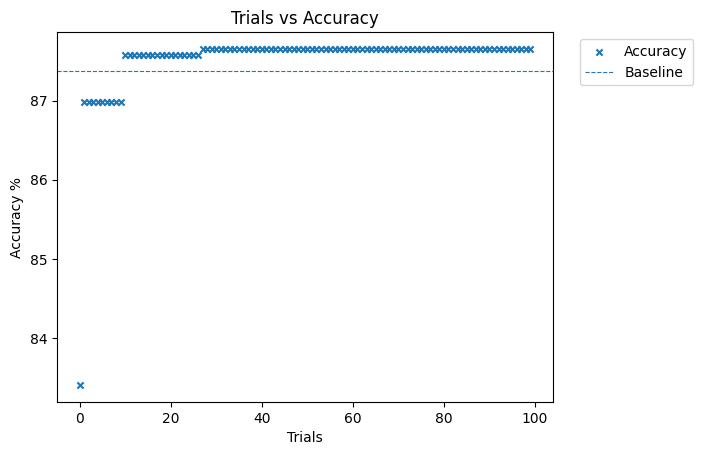

In [12]:
plot('sampler_run_rnd_layers')

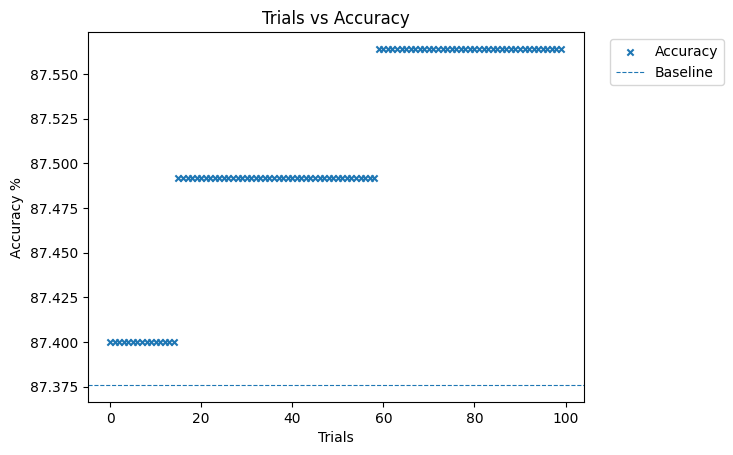

In [13]:
plot('sampler_run_tpes_layers')

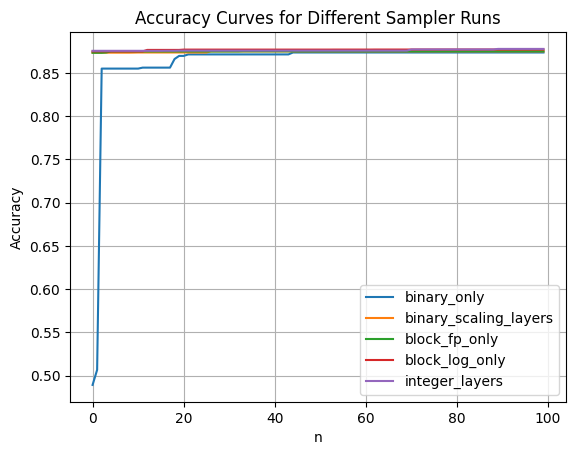

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# List of the exact filenames
csv_files = [
    'sampler_run_binary_only.csv',
    'sampler_run_binary_scaling_layers.csv',
    'sampler_run_block_fp_only.csv',
    'sampler_run_block_log_only.csv',
    'sampler_run_integer_layers.csv',
    # 'sampler_run_log_layers.csv',
    # 'sampler_run_minifloat_denorm_layers.csv',
    # 'sampler_run_minifloat_layers.csv'
]

# Plot each CSV file
for csv_file in csv_files:
    # Load CSV into DataFrame
    df = pd.read_csv(csv_file)

    # Extract the name for the label (after "sampler_run")
    label = csv_file.split("sampler_run_")[1].split(".csv")[0]

    # Plot the accuracy curve
    plt.plot(df['n'], df['accuracy'].cummax(), label=label)

# Customize plot
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves for Different Sampler Runs')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


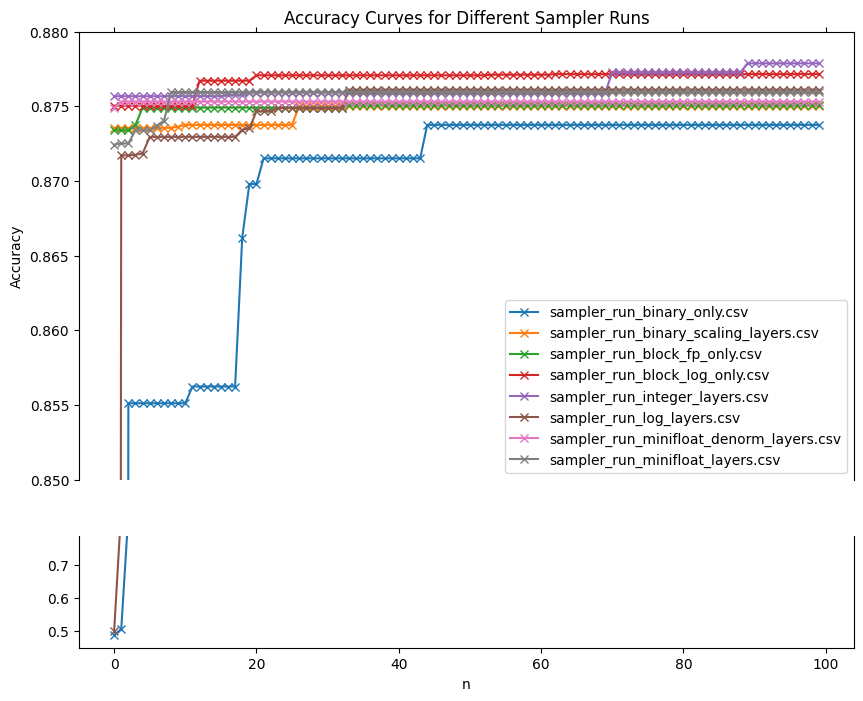

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# List of the exact filenames
csv_files = [
    'sampler_run_binary_only.csv',
    'sampler_run_binary_scaling_layers.csv',
    'sampler_run_block_fp_only.csv',
    'sampler_run_block_log_only.csv',
    'sampler_run_integer_layers.csv',
    'sampler_run_log_layers.csv',
    'sampler_run_minifloat_denorm_layers.csv',
    'sampler_run_minifloat_layers.csv'
]

x_vals = [i for i in range(0, 100)]

fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, gridspec_kw={"height_ratios": [4, 1]}, figsize=(10, 8)
)

for file in csv_files:
    df = pd.read_csv(file)
    ax1.plot(x_vals, df['accuracy'].cummax(), marker='x', label=f'{file}')

    ax2.plot(x_vals, df['accuracy'].cummax(), marker='x', label=f'{file}')

ax1.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

ax2.set_xlabel('n')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Curves for Different Sampler Runs')

ax1.legend()

ax1.set_ylim(0.85, 0.88)  # Set y-axis limits for the upper part
ax2.set_ylim(0.45, 0.79)  # Set y-axis limits for the lower part

plt.savefig(f"{Path.cwd()}/cp_za_wolduh", bbox_inches='tight')
plt.show()